# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-rw-r-- 1 1000 1002 1.2K Feb  5 08:32 README.md


In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_242
Branch 
Compiled by user  on 2019-08-27T21:31:02Z
Revision 
Url 
Type --help for more information.


## Запуск spark

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [4]:
! hdfs dfs -ls .

Found 1 items
drwxr-xr-x   - root supergroup          0 2020-02-04 19:38 data


In [6]:
!hdfs dfs -copyFromLocal ../../data/datalens/data .

In [17]:
!hdfs dfs -ls ./data/ml-1m

Found 4 items
-rw-r--r--   1 root supergroup       5577 2020-02-16 11:27 data/ml-1m/README
-rw-r--r--   1 root supergroup     171308 2020-02-16 11:27 data/ml-1m/movies.dat
-rw-r--r--   1 root supergroup   24594131 2020-02-16 11:27 data/ml-1m/ratings.dat
-rw-r--r--   1 root supergroup     134368 2020-02-16 11:27 data/ml-1m/users.dat


In [10]:
!ls /workspace

apache_spark  docker		 intro	    spark-2.4.4-bin-hadoop2.6.tgz
data	      hadoop_map_reduce  README.md  spark_sql


In [20]:
# DATA_PATH = './data/ml-1m'
DATA_PATH = '/workspace/data/datalens/data/ml-1m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.dat')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.dat')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.dat')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [34]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=':') \
    .load('file:///' + RATINGS_PATH)

In [35]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [36]:
ratings_df.take(5)

[Row(user_id=1, movie_id=1193, rating=5.0, timestamp=978300760),
 Row(user_id=1, movie_id=661, rating=3.0, timestamp=978302109),
 Row(user_id=1, movie_id=914, rating=3.0, timestamp=978301968),
 Row(user_id=1, movie_id=3408, rating=4.0, timestamp=978300275),
 Row(user_id=1, movie_id=2355, rating=5.0, timestamp=978824291)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [37]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [38]:
ratings.take(5)

['userId:movieId:rating:timestamp',
 '1:1193:5:978300760',
 '1:661:3:978302109',
 '1:914:3:978301968',
 '1:3408:4:978300275']

In [39]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(':')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [40]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [43]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ":") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [44]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [45]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=3656, mean_rating=5.0, ratings_count=1, movieId=3656, title='Lured (1947)', genres='Crime'),
 Row(movie_id=1830, mean_rating=5.0, ratings_count=1, movieId=1830, title='Follow the Bitch (1998)', genres='Comedy'),
 Row(movie_id=989, mean_rating=5.0, ratings_count=1, movieId=989, title='Schlafes Bruder (Brother of Sleep) (1995)', genres='Drama'),
 Row(movie_id=3172, mean_rating=5.0, ratings_count=1, movieId=3172, title='Ulysses (Ulisse) (1954)', genres='Adventure'),
 Row(movie_id=3881, mean_rating=5.0, ratings_count=1, movieId=3881, title='Bittersweet Motel (2000)', genres='Documentary'),
 Row(movie_id=3280, mean_rating=5.0, ratings_count=1, movieId=3280, title='Baby, The (1973)', genres='Horror'),
 Row(movie_id=3233, mean_rating=5.0, ratings_count=2, movieId=3233, title='Smashing Time (1967)', genres='Comedy'),
 Row(movie_id=3382, mean_rating=5.0, ratings_count=1, movieId=3382, title='Song of Freedom (1936)', genres='Drama'),
 Row(movie_id=3607, mean_rating=5.0, ratings_cou

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [46]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [47]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,2858,3428,2858,American Beauty (1999),Comedy|Drama
1,260,2991,260,Star Wars,Episode IV - A New Hope (1977)
2,1196,2990,1196,Star Wars,Episode V - The Empire Strikes Back (1980)
3,1210,2883,1210,Star Wars,Episode VI - Return of the Jedi (1983)
4,480,2672,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
5,2028,2653,2028,Saving Private Ryan (1998),Action|Drama|War
6,589,2649,589,Terminator 2,Judgment Day (1991)
7,2571,2590,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
8,1270,2583,1270,Back to the Future (1985),Comedy|Sci-Fi
9,593,2578,593,"Silence of the Lambs, The (1991)",Drama|Thriller


---
## SQL

In [48]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [49]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     318|    2227|Shawshank Redempt...|
|     356|    2194| Forrest Gump (1994)|
|     296|    2171| Pulp Fiction (1994)|
|     377|    1650|        Speed (1994)|
|     223|    1412|       Clerks (1994)|
|     380|    1400|    True Lies (1994)|
|     357|    1233|Four Weddings and...|
|     367|    1179|    Mask, The (1994)|
|     364|    1121|Lion King, The (1...|
|     316|    1116|     Stargate (1994)|
|     349|    1059|Clear and Present...|
|     235|     927|      Ed Wood (1994)|
|     368|     802|     Maverick (1994)|
|     253|     738|Interview with th...|
|     353|     734|    Crow, The (1994)|
|     246|     716|  Hoop Dreams (1994)|
|     266|     705|Legends of the Fa...|
|     300|     705|    Quiz Show (1994)|
|     288|     700|Natural Born Kill...|
|     231|     660|Dumb & Dumber (1994)|
+--------+--------+--------------------+
only showing top

In [50]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#183]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#52L, count(1)#186L, title#183]
+- Sort [count(1)#186L DESC NULLS LAST], true
   +- Aggregate [movie_id#52L], [movie_id#52L, count(1) AS count(1)#186L, first(title#83, false) AS title#183]
      +- Filter title#83 LIKE %(1994)%
         +- Join Inner, (movie_id#52L = cast(movieId#82 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#52L, rating#53, timestamp#54L, user_id#55L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#82,title#83,genres#84] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [51]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [52]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .sort(F.col('year'))\
    .toPandas()

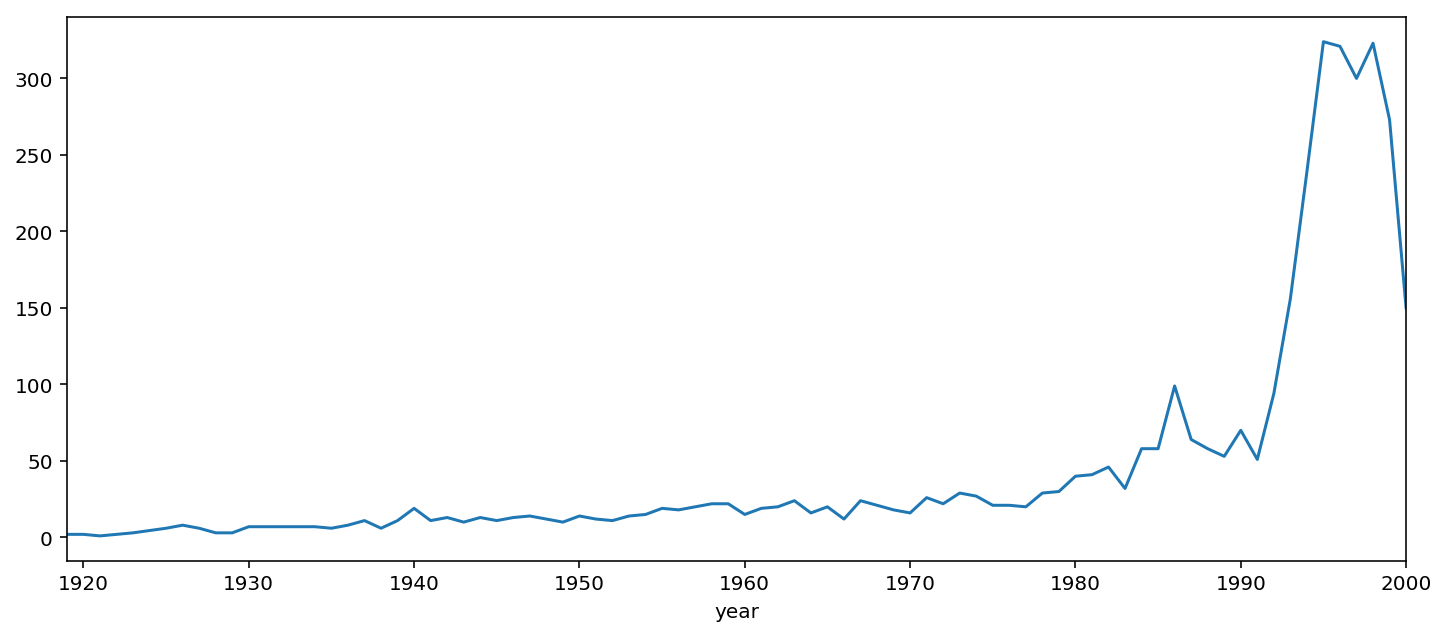

In [53]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [54]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=593, rating=3.0, timestamp=978130429, user_id=26, next_timestamp=978130465),
 Row(movie_id=2915, rating=4.0, timestamp=978130465, user_id=26, next_timestamp=978130485),
 Row(movie_id=511, rating=5.0, timestamp=978130485, user_id=26, next_timestamp=978130485),
 Row(movie_id=480, rating=4.0, timestamp=978130485, user_id=26, next_timestamp=978130684),
 Row(movie_id=3249, rating=3.0, timestamp=978130684, user_id=26, next_timestamp=978130703),
 Row(movie_id=1, rating=3.0, timestamp=978130703, user_id=26, next_timestamp=978130703),
 Row(movie_id=318, rating=4.0, timestamp=978130703, user_id=26, next_timestamp=978130715),
 Row(movie_id=2858, rating=4.0, timestamp=978130715, user_id=26, next_timestamp=978130729),
 Row(movie_id=1704, rating=5.0, timestamp=978130729, user_id=26, next_timestamp=978130782),
 Row(movie_id=337, rating=1.0, timestamp=978130782, user_id=26, next_timestamp=978130782)]

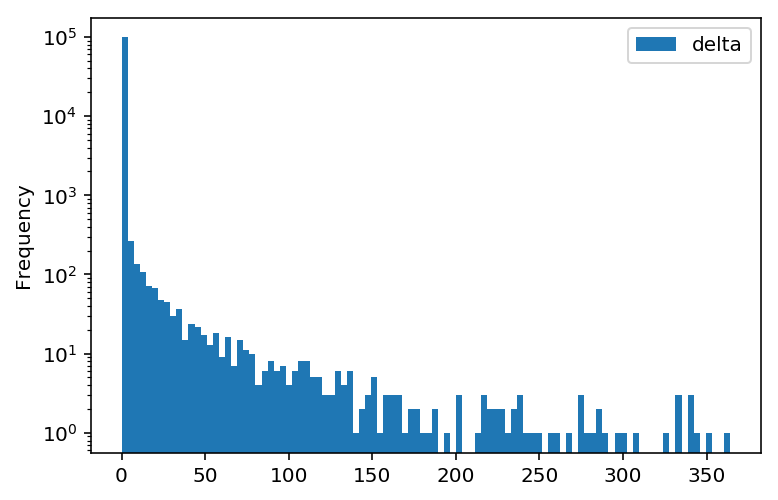

In [55]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [ ]:
# Тут я еще возвращаю сам фильм. Эту строку можно фильтрануть, но мне так просто намного удобнее было дебагать
# и быть +- уверенным, что все нормально отработало

In [148]:
def top_sim(base_movie_id, n):
    rated_base_movie_df = ratings_df \
            .select(['user_id', 'movie_id']) \
            .withColumn('rated_base', (F.col('movie_id') == F.lit(base_movie_id)).cast('integer')) \
            .select(['user_id', 'rated_base']) \
            .groupby('user_id') \
            .agg(F.max('rated_base').alias('rated_base'))
    
    base_movie_U = rated_base_movie_df.select('rated_base').groupBy().sum().collect()[0][0]
    
    return ratings_df \
            .select(['movie_id', 'user_id']) \
            .join(rated_base_movie_df, on='user_id') \
            .groupby('movie_id') \
            .agg(F.count('user_id').alias('U_i'), F.sum('rated_base').alias('cap')) \
            .sort(F.col('cap').desc()) \
            .withColumn('sim', F.col('cap') / (F.col('U_i') + F.lit(base_movie_U) - F.col('cap'))) \
            .select(['movie_id', 'sim']) \
            .join(movies_df, movies_df['movieId'] == F.col('movie_id')) \
            .select(['sim', 'movie_id', 'title']) \
            .sort(F.col('sim').desc()) \
            .limit(n + 1)

In [149]:
top_sim(356, 10).show() # Forrest Gump 356

+-------------------+--------+--------------------+
|                sim|movie_id|               title|
+-------------------+--------+--------------------+
|                1.0|     356| Forrest Gump (1994)|
|0.46382978723404256|    1265|Groundhog Day (1993)|
|0.40354912914886626|       1|    Toy Story (1995)|
| 0.4033214709371293|    1580| Men in Black (1997)|
|0.38514548238897395|    1784|As Good As It Get...|
|0.38023692574400464|    1270|Back to the Futur...|
|  0.377771461057419|    2028|Saving Private Ry...|
| 0.3770869314910766|    2571|  Matrix, The (1999)|
|0.37652681890600104|    1196|           Star Wars|
| 0.3758052970651396|     377|        Speed (1994)|
| 0.3752462245567958|     457|Fugitive, The (1993)|
+-------------------+--------+--------------------+



Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [144]:
def pop(n):
    return ratings_df \
        .select(['movie_id', 'user_id']) \
        .groupby('movie_id') \
        .agg(F.count('user_id').alias('pop')) \
        .join(movies_df, movies_df['movieId'] == ratings_df['movie_id']) \
        .select(['pop', 'title', 'movie_id']) \
        .sort(F.col('pop').desc()) \
        .limit(n)

In [145]:
pop(10).show()

+----+--------------------+--------+
| pop|               title|movie_id|
+----+--------------------+--------+
|3428|American Beauty (...|    2858|
|2991|           Star Wars|     260|
|2990|           Star Wars|    1196|
|2883|           Star Wars|    1210|
|2672|Jurassic Park (1993)|     480|
|2653|Saving Private Ry...|    2028|
|2649|        Terminator 2|     589|
|2590|  Matrix, The (1999)|    2571|
|2583|Back to the Futur...|    1270|
|2578|Silence of the La...|     593|
+----+--------------------+--------+



### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [ ]:
# Не придумал как делать нормально. Весь код ниже -- просто так оставил, он совсем неправильный

In [187]:
# Я не хочу строить огромную таблицу попарных похожестей movie x movie
# а использовать создвать udf, которые сами внутри себя юзают спарк нельзя
# поэтому такое корявое решение, хз как сделать лучше

def item_knn(u, I, n):
    movies = list(map(lambda x: x[0], ratings_df \
        .filter(F.col('user_id') == F.lit(u)) \
        .select('movie_id') \
        .collect()))
    
    m_sim = [kv for m in movies for kv in I(m, n)]
    
    return sorted(m_sim, key=lambda kv: -kv[1])[:n]

In [ ]:
# just checking that it works...

# first, define I
I = lambda movie_id, n: list(map(lambda x: (x[0], x[1]), top_sim(movie_id, n).select(['movie_id', 'sim']).rdd.collect()[:5]))
# I(356, 10)

# now run item_knn
item_knn(123, I, 10).show()

## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [77]:
def train_val_test(a, b):
    N = ratings_df.count()
    n_train = a / 100 * N
    n_val = n_train + b / 100 * N

    row_window = Window.orderBy('timestamp')

    tmp_df = ratings_df \
        .sort('timestamp') \
        .withColumn('row_number',  F.row_number().over(row_window))
    
    train = tmp_df.filter(F.col('row_number') < n_train)
    val = tmp_df.filter(F.col('row_number') > n_train).filter(F.col('row_number') < n_val)
    test = tmp_df.filter(F.col('row_number') >= n_val)
    
    return (train, val, test)

In [78]:
train, val, test = train_val_test(80, 10)

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################